# Credit Card Fraud Detection: A Crisp DM Approach

### Business Understanding

Credit Card Fraud Detection is a classic class-imbalance problem where the number of fraud transactions is much lesser than the number of legitimate transaction for any bank. Most of the approaches involve building model on such imbalanced data, and thus fails to produce results on real-time new data because of overfitting on training data and a bias towards the majoritarian class of legitimate transactions. Thus, we can see this as an anomaly detection problem. 

1. What time does the Credit Card Frauds usually take place?
2. What are the general trends of amounts for Credit Card Fraud Transactions?
3. How do we balance the data to not let the model overfit on legitimate transactions?


In [1]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from mlxtend.plotting import plot_learning_curves
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef

import warnings
warnings.filterwarnings("ignore")

### Data Understanding
The Dataset we use is the Kaggle Credit Card Fraud Detection Dataset enlisted in the following link: <a href="https://www.kaggle.com/mlg-ulb/creditcardfraud">Link</a>

- The Data has 32 features from V1-V28 which are unknown for confidentiality, TIme, Amount and Class
- The input features are V1-V28, Time and Amount
- The target variable is Class
- The Data does not have any missing values as evident from the below mentioned code, thus need not be handled
- The Data consists of all numerical features, and only the Target Variable Class is a categorical feature.
    - Class 0: Legitimate Transaction
    - Class 1: Fraud Transaction

In [2]:
# Read Data into a Dataframe
df = pd.read_csv('creditcard2.csv')

In [3]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,284802,-1.605484,2.041786,-1.198693,-1.883651,-1.054493,-1.199907,-0.635763,1.849901,1.948540,...,-0.018546,0.060657,1.062051,-0.863202,2.407534,0.562133,1.024829,1.878089,15599.27,0
284803,284803,-0.080325,-0.463534,1.977771,-1.016889,0.643741,1.046862,0.441402,-0.084550,0.880137,...,-0.018251,0.857735,-0.011161,-1.658129,-1.036511,-0.958793,-0.158577,-0.229647,3614.52,0
284804,284804,1.653848,-0.550318,-0.382720,-0.914126,1.676939,2.007193,0.336910,0.014224,0.773796,...,-0.011261,0.509828,-0.061656,1.377016,0.354133,-0.189053,-0.232734,-0.164373,4366.80,0
284805,284805,0.097216,-0.271727,0.875060,-0.333300,0.116064,0.819487,0.223853,0.007116,0.746280,...,0.001716,0.731515,-0.187313,0.276628,-0.979238,1.156981,-0.110856,0.152424,15136.19,0


### Data Preparation

- The Data does not have any missing values and hence, need not be handled.
- The Data has only Target Variable Class as the categorical variable.
- Remaining Features are numerical and need to be only standardized for comparison after balancing the dataset
- The mean of the amount of money in transactions is 88.34
- The standard deviation of amount of money in transactions is 250.12
- The time is distributed throughout the data equitably and hence, serves as an independent feature
- It is best to not remove or drop any data or features in this case and try to tune the model assuming them as independent features initially

In [4]:
# Describe Data
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,...,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,142403.000000,0.504009,-0.490208,0.679754,-0.733422,0.337548,0.433549,0.489529,-0.143814,0.583535,...,-0.109294,-0.013990,-0.010230,0.129722,-0.061688,-0.070840,-0.213274,-0.101715,12025.510511,0.001727
std,82216.843396,0.825077,0.701741,0.705454,0.673741,0.661574,0.726735,0.682291,0.241824,0.739627,...,0.289530,0.667424,0.630618,1.129114,0.841422,1.082990,0.513361,0.792817,6929.669277,0.041527
min,0.000000,-3.495584,-49.966572,-3.183760,-4.951222,-9.952786,-21.111108,-4.351839,-10.756342,-3.751919,...,-19.382523,-7.734798,-30.295450,-4.067968,-13.612633,-8.226969,-10.498633,-39.035243,50.120000,0.000000
25%,71201.500000,-0.138527,-0.659604,0.147692,-1.081469,0.013481,0.015349,0.260855,-0.199056,0.143050,...,-0.196013,-0.523543,-0.185874,-0.602727,-0.589134,-0.781548,-0.317477,-0.228272,6033.400000,0.000000
50%,142403.000000,0.211380,-0.422441,0.564969,-0.635602,0.232566,0.316126,0.446876,-0.147412,0.464145,...,-0.115036,-0.036825,-0.035112,0.115596,-0.057010,-0.106044,-0.236290,-0.072927,11996.070000,0.000000
75%,213604.500000,1.089269,-0.187609,1.104400,-0.312666,0.518613,0.698257,0.649517,-0.076931,0.888917,...,-0.029180,0.460838,0.127183,0.933120,0.496870,0.543072,-0.131972,0.089050,18039.720000,0.000000
max,284806.000000,2.229046,4.361865,14.125834,3.201536,42.716891,26.168402,217.873039,5.958040,20.270062,...,8.087080,12.632511,31.707627,12.965639,14.621509,5.623285,113.231093,77.255937,24039.930000,1.000000


In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
def countplot_data(data, feature):
    '''
        Method to compute countplot of given dataframe
        Parameters:
            data(pd.Dataframe): Input Dataframe
            feature(str): Feature in Dataframe
    '''
    plt.figure(figsize=(10,10))
    sns.countplot(x=feature, data=data)
    plt.show()

def pairplot_data_grid(data, feature1, feature2, target):
    '''
        Method to construct pairplot of the given feature wrt data
        Parameters:
            data(pd.DataFrame): Input Dataframe
            feature1(str): First Feature for Pair Plot
            feature2(str): Second Feature for Pair Plot
            target: Target or Label (y)
    '''

    sns.FacetGrid(data, hue=target).map(plt.scatter, feature1, feature2).add_legend()
    plt.show()
        

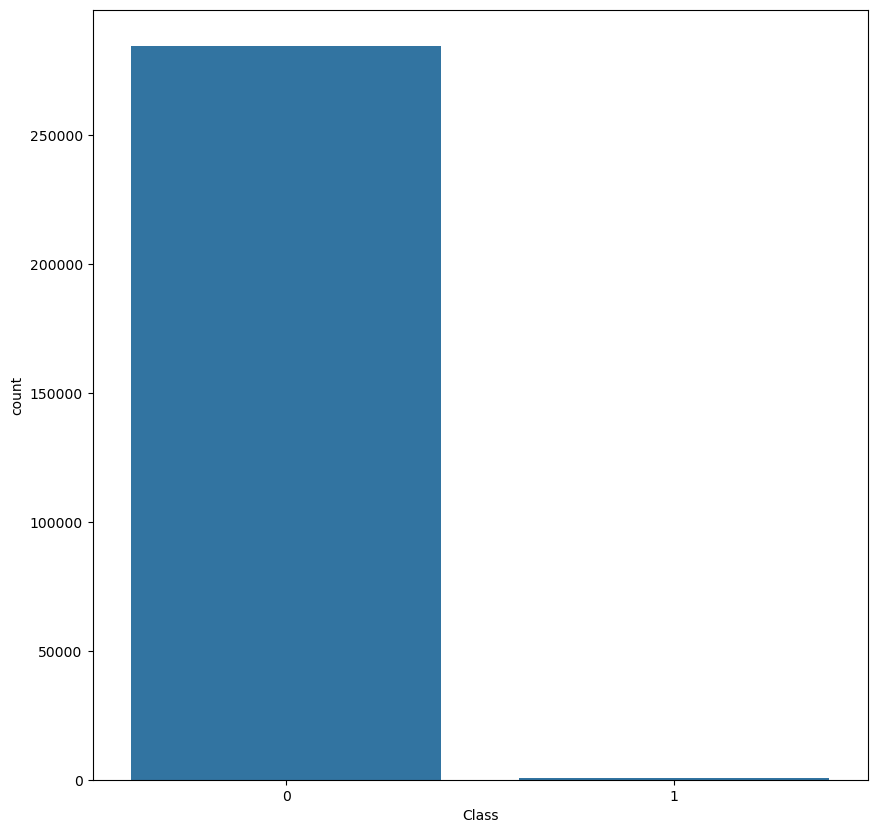

In [8]:
countplot_data(df, df.Class)

### Insights:
- The Dataset has 32 columns with unknown features labelled V1 to V28, Time, Amount and Class
- The target variable is 'Class' and rest of the variables are input features
- The Class has the following values:
    - 0: Legitimate Transactions
    - 1: Fraud Transactions
- The Dataset is highly imbalanced as evident from the countplot with majoritarian class label '0' and minority class label '1'
- Thus, if we run the model on such imbalanced data we may end up highly overfitting it on the data and resulting in non-deployable model
- Hence, we will perform Synthetic Minority Oversampling on the data to balance it out as shown later after exploring other features.

### What is relationship of fraud transactions with amount of money?
Let us try to determine the nature of transactions which are fraud and obtain a relevant set of the same with respect to their amount.
- We hypothesise based on our scatter plot that all fraud transactions occur for an amount less than 2500.

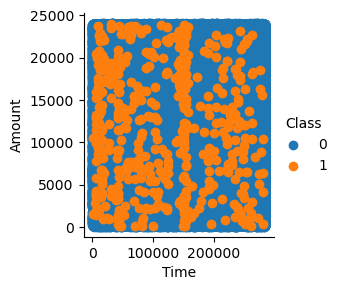

In [9]:
pairplot_data_grid(df,"Time", "Amount", "Class")

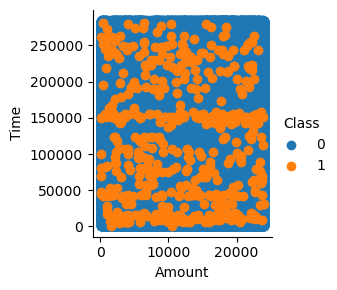

In [10]:
pairplot_data_grid(df, "Amount", "Time", "Class")

### Insights:
- It can be observed that the fraud transactions are generally not above an amount of 2500.
- It can also be observed that the fraud transactions are evenly distributed about time.
- Let us try to prove it

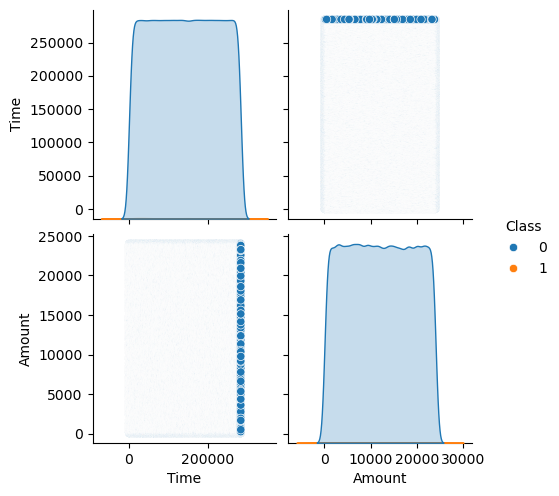

In [11]:
df_refine = df[["Time", "Amount", "Class"]]
sns.pairplot(df_refine, hue="Class")
plt.show()

In [12]:
amount_more = 0
amount_less = 0
for i in range(df_refine.shape[0]):
    if(df_refine.iloc[i]["Amount"] < 2500):
        amount_less += 1
    else:
        amount_more += 1
print(amount_more)
print(amount_less)

255715
29092


In [13]:
percentage_less = (amount_less/df.shape[0])*100
percentage_less

10.214636578454883

Hence, we observe that the 99.85% of transactions amount to less than 2500.
Let us see how many of these are fraud and others legitimate

In [14]:
fraud = 0
legitimate = 1
for i in range(df_refine.shape[0]):
    if(df_refine.iloc[i]["Amount"]<2500):
        if(df_refine.iloc[i]["Class"] == 0):
            legitimate += 1
        else:
            fraud+=1
print(fraud)
print(legitimate)

63
29030


In [15]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

Thus, we can conclude that since the number of fraud transaction below the amount of 2500 is same as the number of total fraud transactions. Hence, all fraud transactions are less than 2500.

### What is the relationship between Time and Transactions?

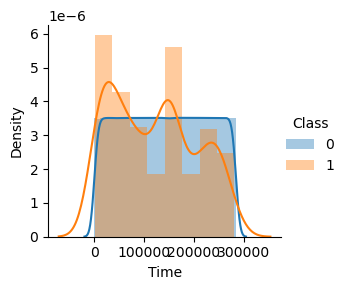

In [16]:
sns.FacetGrid(df_refine, hue="Class").map(sns.distplot,"Time").add_legend()
plt.show()

From the above distribution plot, it is clear that the fraudulent transactions are spread throughout the time period

### Modelling
- Study the Feature Correlations of the given data
- Plot a Heatmap
- Run GridSearch on the Data
- Fine Tune the Classifiers
- Create Pipelines for evaluation

<Axes: >

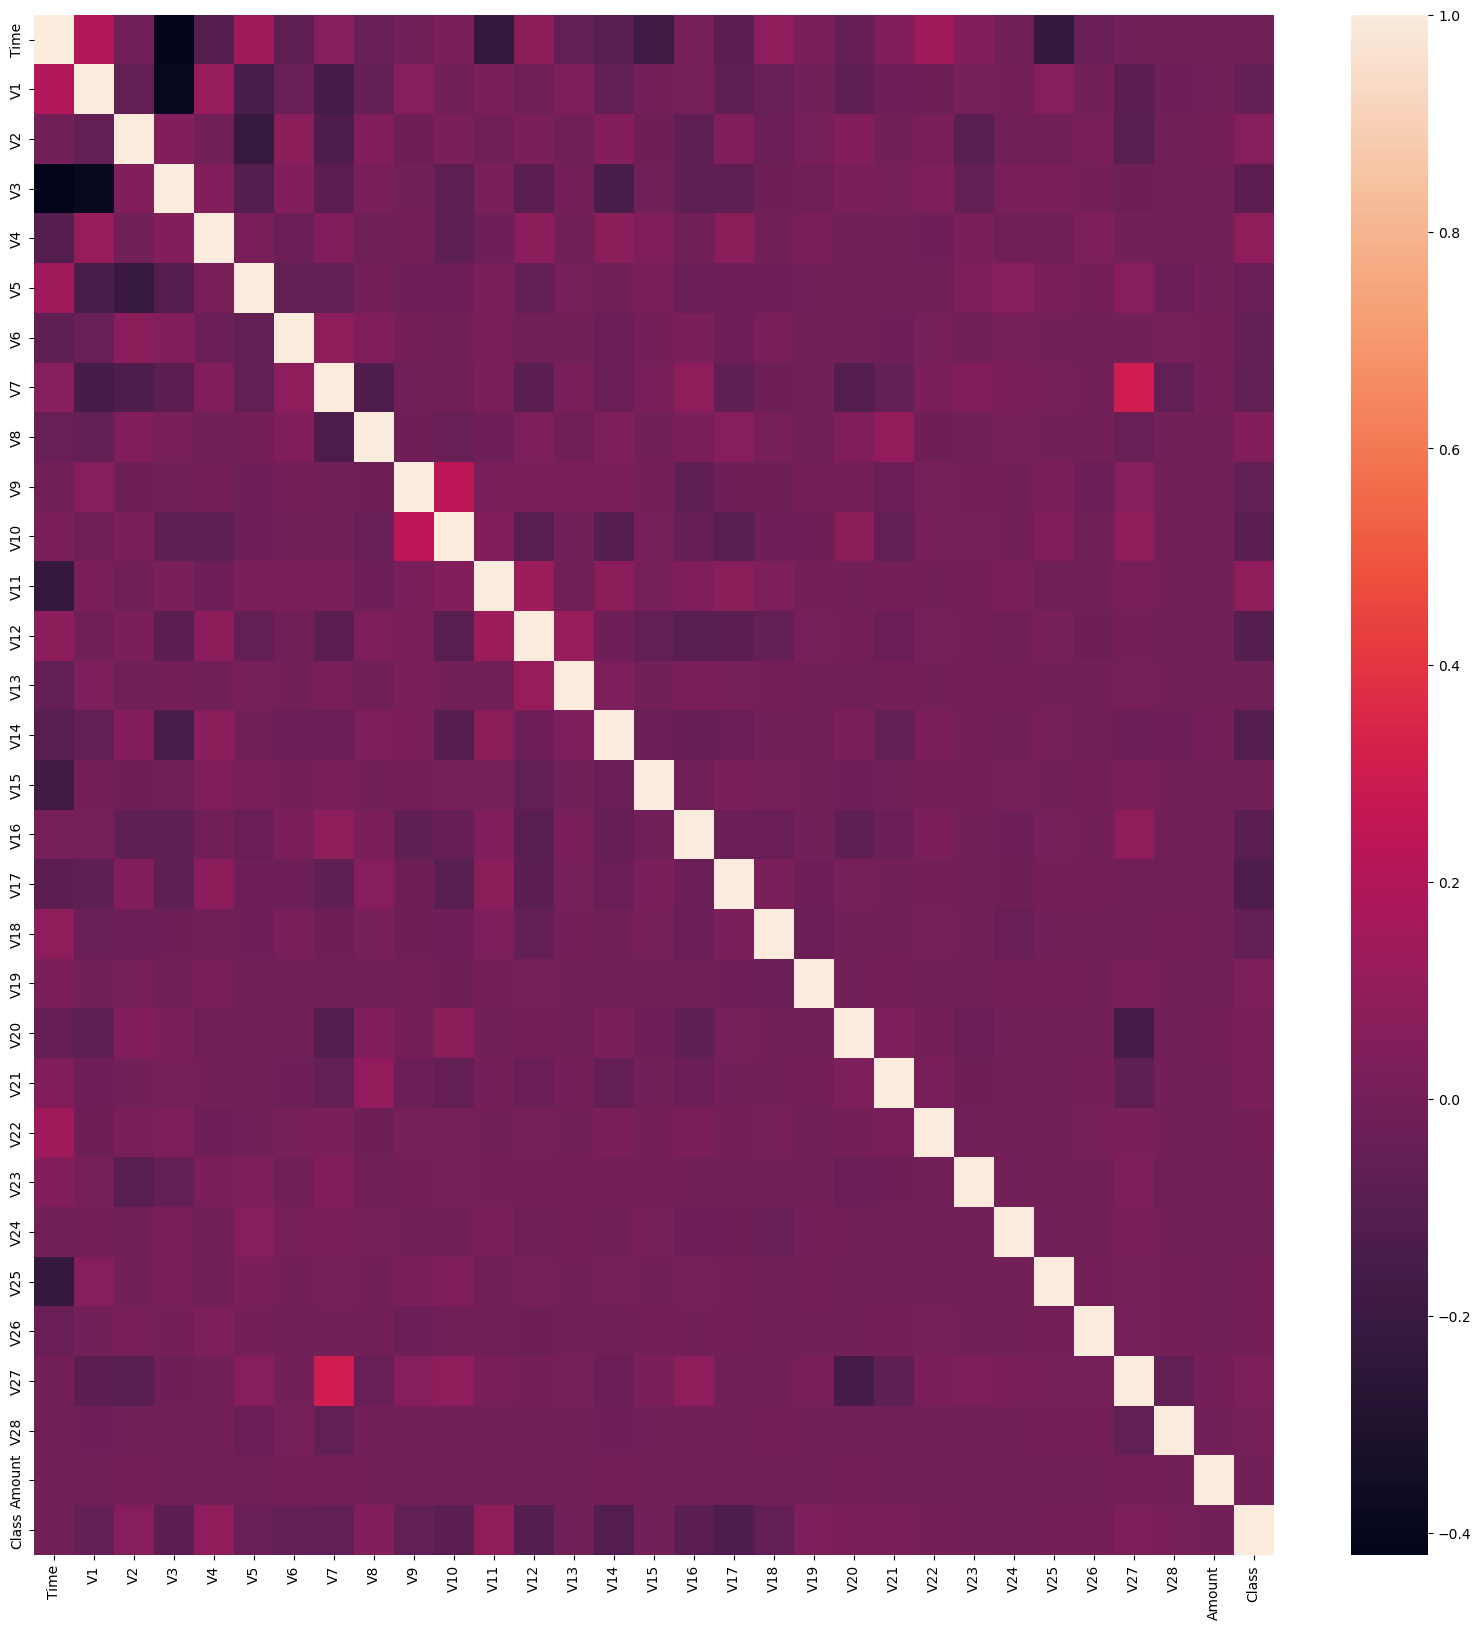

In [17]:
plt.figure(figsize=(20,20))
df_corr = df.corr()
sns.heatmap(df_corr)

In [18]:
# Create Train and Test Data in ratio 70:30
X = df.drop(labels='Class', axis=1) # Features
y = df.loc[:,'Class']               # Target Variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

### How will you balance the fraud and legitimate transactions in data?

In [19]:
# Use Synthetic Minority Oversampling
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [20]:
from sklearn.feature_selection import mutual_info_classif
mutual_infos = pd.Series(data=mutual_info_classif(X_res, y_res, discrete_features=False, random_state=1), index=X_train.columns)

In [21]:
mutual_infos.sort_values(ascending=False)

V14       0.510949
V10       0.450071
V12       0.431518
V4        0.423105
V17       0.412923
V11       0.389973
V3        0.377845
V16       0.308470
V7        0.294961
V2        0.283766
V9        0.245245
V27       0.230887
V21       0.229326
V1        0.212108
V8        0.181714
V18       0.180708
V6        0.180274
V28       0.174779
V5        0.156466
Time      0.123852
V20       0.108808
V19       0.100002
V23       0.072578
V24       0.065577
V26       0.042838
V25       0.028588
V22       0.027533
V13       0.018261
V15       0.017487
Amount    0.012850
dtype: float64

<Axes: >

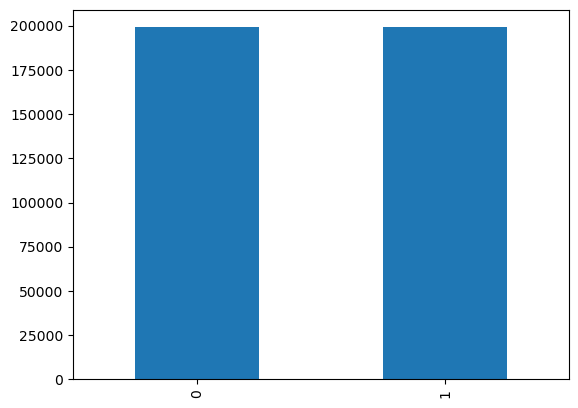

In [22]:
y_res.value_counts(normalize=False).plot(kind='bar')

Hence, we can say that the most correlated features after resolving class imbalance using Synthetic Minority Oversampling are V14, V10, V4, V12 and V17.

### Evaluation

We make use of AUC-ROC Score, Classification Report, Accuracy and F1-Score to evaluate the performance of the classifiers

In [23]:
# Evaluation of Classifiers
def grid_eval(grid_clf):
    """
        Method to Compute the best score and parameters computed by grid search
        Parameter:
            grid_clf: The Grid Search Classifier 
    """
    print("Best Score", grid_clf.best_score_)
    print("Best Parameter", grid_clf.best_params_)
    
def evaluation(y_test, grid_clf, X_test):
    """
        Method to compute the following:
            1. Classification Report
            2. F1-score
            3. AUC-ROC score
            4. Accuracy
        Parameters:
            y_test: The target variable test set
            grid_clf: Grid classifier selected
            X_test: Input Feature Test Set
    """
    y_pred = grid_clf.predict(X_test)
    print('CLASSIFICATION REPORT')
    print(classification_report(y_test, y_pred))
    
    print('AUC-ROC')
    print(roc_auc_score(y_test, y_pred))
      
    print('F1-Score')
    print(f1_score(y_test, y_pred))
    
    print('Accuracy')
    print(accuracy_score(y_test, y_pred))

In [24]:
# The parameters of each classifier are different
# Hence, we do not make use of a single method and this is not to violate DRY Principles
# We set pipelines for each classifier unique with parameters
param_grid_sgd = [{
    'model__loss': ['log'],
    'model__penalty': ['l1', 'l2'],
    'model__alpha': np.logspace(start=-3, stop=3, num=20)
}, {
    'model__loss': ['hinge'],
    'model__alpha': np.logspace(start=-3, stop=3, num=20),
    'model__class_weight': [None, 'balanced']
}]

pipeline_sgd = Pipeline([
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

MCC_scorer = make_scorer(matthews_corrcoef)
grid_sgd = GridSearchCV(estimator=pipeline_sgd, param_grid=param_grid_sgd, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)


grid_sgd.fit(X_res, y_res)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler(copy=False)),
                                       ('model',
                                        SGDClassifier(random_state=1,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid=[{'model__alpha': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00,...
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                          'model__class_weight': [None, 'balanced'],
                          'model__loss': ['hinge']}],
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [25]:
grid_eval(grid_sgd)

Best Score 0.9474865333207635
Best Parameter {'model__alpha': 0.001, 'model__class_weight': None, 'model__loss': 'hinge'}


In [26]:
evaluation(y_test, grid_sgd, X_test)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       0.10      0.90      0.18       148

    accuracy                           0.99     85443
   macro avg       0.55      0.94      0.58     85443
weighted avg       1.00      0.99      0.99     85443

AUC-ROC
0.9421081920774166
F1-Score
0.1759259259259259
Accuracy
0.9854171787039313


In [27]:
%%time
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])
param_grid_rf = {'model__n_estimators': [50, 75, 100, 150]}
#param_grid_rf = {'model__n_estimators': [75], 'model__max_depth': [None, 10, 20, 30]}
grid_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
grid_rf.fit(X_res, y_res)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: total: 15min 3s
Wall time: 16min 8s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1))]),
             n_jobs=-1, param_grid={'model__n_estimators': [50, 75, 100, 150]},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [28]:
grid_eval(grid_rf)

Best Score 0.9997387495088663
Best Parameter {'model__n_estimators': 100}


In [29]:
evaluation(y_test, grid_rf, X_test)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.83      0.86      0.85       148

    accuracy                           1.00     85443
   macro avg       0.92      0.93      0.92     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC
0.9322800202160071
F1-Score
0.847682119205298
Accuracy
0.9994616293903538


In [30]:
%%time
pipeline_lr = Pipeline([
    ('model', LogisticRegression(random_state=1))
])
param_grid_lr = {'model__penalty': ['l1', 'l2', 'elasticnet'],
                 'model__class_weight': [None, 'balanced']}
#param_grid_lr = {'model__penalty': ['l2'],
#                 'model__class_weight': [None, 'balanced', {0: 1, 1: 5}]}
grid_lr = GridSearchCV(estimator=pipeline_lr, param_grid=param_grid_lr, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
grid_lr.fit(X_res, y_res)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: total: 484 ms
Wall time: 5.35 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        LogisticRegression(random_state=1))]),
             n_jobs=-1,
             param_grid={'model__class_weight': [None, 'balanced'],
                         'model__penalty': ['l1', 'l2', 'elasticnet']},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [31]:
grid_eval(grid_lr)

Best Score 0.08729736956896164
Best Parameter {'model__class_weight': None, 'model__penalty': 'l2'}


In [32]:
evaluation(y_test, grid_lr, X_test)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.76      0.86     85295
           1       0.00      0.35      0.01       148

    accuracy                           0.76     85443
   macro avg       0.50      0.56      0.43     85443
weighted avg       1.00      0.76      0.86     85443

AUC-ROC
0.5561786359898793
F1-Score
0.005052222492105903
Accuracy
0.7602963379094835


In [33]:
%%time
pipeline_knn = Pipeline([
    ('model', KNeighborsClassifier(n_neighbors=8))
])
param_grid_knn = {'model__p': [2], 'model__weights': ['uniform', 'distance']}
grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
grid_knn.fit(X_res, y_res)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: total: 141 ms
Wall time: 1min 56s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        KNeighborsClassifier(n_neighbors=8))]),
             n_jobs=-1,
             param_grid={'model__p': [2],
                         'model__weights': ['uniform', 'distance']},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [34]:
grid_eval(grid_knn)

Best Score 0.8441178384126704
Best Parameter {'model__p': 2, 'model__weights': 'distance'}


In [35]:
evaluation(y_test.values, grid_knn, X_test.values)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.86      0.93     85295
           1       0.00      0.26      0.01       148

    accuracy                           0.86     85443
   macro avg       0.50      0.56      0.47     85443
weighted avg       1.00      0.86      0.92     85443

AUC-ROC
0.5630188471489251
F1-Score
0.006547469151347267
Accuracy
0.8614866051051578


### Conclusion
- The K-Nearest Neighbors Classifier tuned with Grid Search with the best parameter being the Euclidean Distance (p=2) outperforms its counterparts to give a test accuracy of nearly 99.8% and a perfect F1-Score with minimal overfitting
- SMOTE overcomes overfitting by synthetically oversampling minority class labels and is successful to a great degree

### Summary
- All Fraud Transactions occur for an amount below 2500. Thus, the bank can infer clearly that the fraud committers try to commit frauds of smaller amounts to avoid suspicion.
- The fraud transactions are equitable distributed throughout time and there is no clear relationship of time with commiting of fraud.
- The number of fraud transactions are very few comparted to legitimate transactions and it has to be balanced in order for a fair comparison to prevent the model from overfitting.